## Scraping Data Review Tokopedia in Google Play

In [4]:
# pip install google-play-scraper

  Obtaining dependency information for google-play-scraper from https://files.pythonhosted.org/packages/33/f7/a23ef3cf8efc9ab3aee565971f59906811e6ce95475314ef7b18d02f30ba/google_play_scraper-1.2.7-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/50.2 kB ? eta -:--:--
     --------------- ---------------------- 20.5/50.2 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 50.2/50.2 kB 512.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import string
import nltk
import matplotlib
import warnings
warnings.filterwarnings('ignore')
from google_play_scraper import app, Sort, reviews
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
# scrape all avaiable reviews

'''
from google_play_scraper import Sort, review_all

result = review_all(
    'com.gojek.app',
    sleep_millisecond=0,
    lang='id',
    country='id'
    sort=Sort.NEWEST
)
'''

"\nfrom google_play_scraper import Sort, review_all\n\nresult = review_all(\n    'com.gojek.app&hl=en-ID',\n    sleep_millisecond=0,\n    lang='id',\n    country='id'\n    sort=Sort.NEWEST\n)\n"

In [72]:
# scrape desired number of reviews

result, continuation_token = reviews(
    'com.tokopedia.tkpd',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=10000,
    filter_score_with=None
)

In [73]:
df = pd.DataFrame(np.array(result),columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))
df.head()

reviewId         userName  \
0  d9033849-82d0-4dbd-b00e-a0cdc1bb57b4  Pengguna Google   
1  57e835fc-a5e8-474d-a68d-68903bc2ad51  Pengguna Google   
2  21114fba-a548-460f-9d76-d881da7e7ab7  Pengguna Google   
3  a8f22458-0c21-4fbd-9694-c1e2c2ae7d4e  Pengguna Google   
4  5bafad1c-3280-4b34-9a1c-97e4fe7e909b  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  Buruk dalam segala hal ! Tutup aja mending lah...      1             62   
1  Belanja di sini banyak yg murah sih, apalagi t...      3             30   
2  semakin lama sama saja seperti toko oren 👎 ......      2             34   
3  Khusus pengguna baru harap hati2 soalnya saya ...      1             29   
4  Perbaiki lagi bisnis proses disistem kalian, s...      1             42   

  reviewCreatedVersion                  at  \
0                3.266 2024-06-07 20:53:15   
1                3.266 2024-06-09 10:13:54   
2                3.266 2024-06-07 02:04:42   
3                3.266 2024-06-07 23:00:45   
4                3.266 2024-06-06 18:58:53   

                                        replyContent           repliedAt  \
0  Toppers, mohon maaf atas kendala yang kamu ala... 2024-06-07 21:00:02   
1  Makasih ratingnya, Toppers. Ke depannya kami a... 2024-06-09 10:20:04   
2  Hi Toppers, silakan sampaikan kritik/saran ata... 2024-06-07 02:20:03   
3  Toppers, mohon maaf atas kendala yang kamu ala... 2024-06-07 23:40:14   
4  Halo Toppers, terima kasih atas rating yang ka... 2024-06-06 19:00:13   

  appVersion  
0      3.266  
1      3.266  
2      3.266  
3      3.266  
4      3.266

In [74]:
len(df.index)

10000

In [75]:
df[['userName','score','at','content']].head()

userName  score                  at  \
0  Pengguna Google      1 2024-06-07 20:53:15   
1  Pengguna Google      3 2024-06-09 10:13:54   
2  Pengguna Google      2 2024-06-07 02:04:42   
3  Pengguna Google      1 2024-06-07 23:00:45   
4  Pengguna Google      1 2024-06-06 18:58:53   

                                             content  
0  Buruk dalam segala hal ! Tutup aja mending lah...  
1  Belanja di sini banyak yg murah sih, apalagi t...  
2  semakin lama sama saja seperti toko oren 👎 ......  
3  Khusus pengguna baru harap hati2 soalnya saya ...  
4  Perbaiki lagi bisnis proses disistem kalian, s...

In [76]:
# run this code to sort the date by date

df2 = df[['userName','score','at','content']]
sorted_df2 = df2.sort_values(by='at',ascending=False)
sorted_df2.head()

userName  score                  at  \
1101  Pengguna Google      5 2024-06-10 17:49:35   
1457  Pengguna Google      4 2024-06-10 09:12:58   
2545  Pengguna Google      3 2024-06-09 19:24:57   
1759  Pengguna Google      1 2024-06-09 18:38:11   
3628  Pengguna Google      5 2024-06-09 18:17:32   

                                                content  
1101  Thanks udah bisa digunakan. Apa benar Tokopedi...  
1457               Kurir rekomendasi Pengiriman lamaaaa  
2545  Sayang sekali appk Tokopedia tidak ada map saa...  
1759  Loading muluu, pas mau milih metode pembayaran...  
3628      Harga barangnya murah dan berkualitas premium

In [77]:
data = sorted_df2[['userName','score','at','content']]
data.head()

userName  score                  at  \
1101  Pengguna Google      5 2024-06-10 17:49:35   
1457  Pengguna Google      4 2024-06-10 09:12:58   
2545  Pengguna Google      3 2024-06-09 19:24:57   
1759  Pengguna Google      1 2024-06-09 18:38:11   
3628  Pengguna Google      5 2024-06-09 18:17:32   

                                                content  
1101  Thanks udah bisa digunakan. Apa benar Tokopedi...  
1457               Kurir rekomendasi Pengiriman lamaaaa  
2545  Sayang sekali appk Tokopedia tidak ada map saa...  
1759  Loading muluu, pas mau milih metode pembayaran...  
3628      Harga barangnya murah dan berkualitas premium

In [78]:
# # save data into csv
# data.to_csv("scrap_data_tokped.csv", index=False)

# NLP (Natural Language Processing)

In [2]:
# random seed
np.random.seed(300)

In [3]:
# read data
data = pd.read_csv("scrap_data_tokped.csv")
data.head()

userName  score                   at  \
0  Pengguna Google      5  2024-06-10 17:49:35   
1  Pengguna Google      4  2024-06-10 09:12:58   
2  Pengguna Google      3  2024-06-09 19:24:57   
3  Pengguna Google      1  2024-06-09 18:38:11   
4  Pengguna Google      5  2024-06-09 18:17:32   

                                             content  
0  Thanks udah bisa digunakan. Apa benar Tokopedi...  
1               Kurir rekomendasi Pengiriman lamaaaa  
2  Sayang sekali appk Tokopedia tidak ada map saa...  
3  Loading muluu, pas mau milih metode pembayaran...  
4      Harga barangnya murah dan berkualitas premium

In [4]:
# add columns year, month, day

data['at'] = pd.to_datetime(data['at'])
data['year'] = data['at'].dt.year
data['month'] = data['at'].dt.month
data['day'] = data['at'].dt.day
data.head()

userName  score                  at  \
0  Pengguna Google      5 2024-06-10 17:49:35   
1  Pengguna Google      4 2024-06-10 09:12:58   
2  Pengguna Google      3 2024-06-09 19:24:57   
3  Pengguna Google      1 2024-06-09 18:38:11   
4  Pengguna Google      5 2024-06-09 18:17:32   

                                             content  year  month  day  
0  Thanks udah bisa digunakan. Apa benar Tokopedi...  2024      6   10  
1               Kurir rekomendasi Pengiriman lamaaaa  2024      6   10  
2  Sayang sekali appk Tokopedia tidak ada map saa...  2024      6    9  
3  Loading muluu, pas mau milih metode pembayaran...  2024      6    9  
4      Harga barangnya murah dan berkualitas premium  2024      6    9

In [5]:
# select the columns to use

df = data[['content','score','year','month','day']]
df.head()

content  score  year  month  day
0  Thanks udah bisa digunakan. Apa benar Tokopedi...      5  2024      6   10
1               Kurir rekomendasi Pengiriman lamaaaa      4  2024      6   10
2  Sayang sekali appk Tokopedia tidak ada map saa...      3  2024      6    9
3  Loading muluu, pas mau milih metode pembayaran...      1  2024      6    9
4      Harga barangnya murah dan berkualitas premium      5  2024      6    9

In [6]:
# score count

df['score'].value_counts()

score
1    5382
5    2314
2     920
3     813
4     571
Name: count, dtype: int64

<Axes: xlabel='score'>

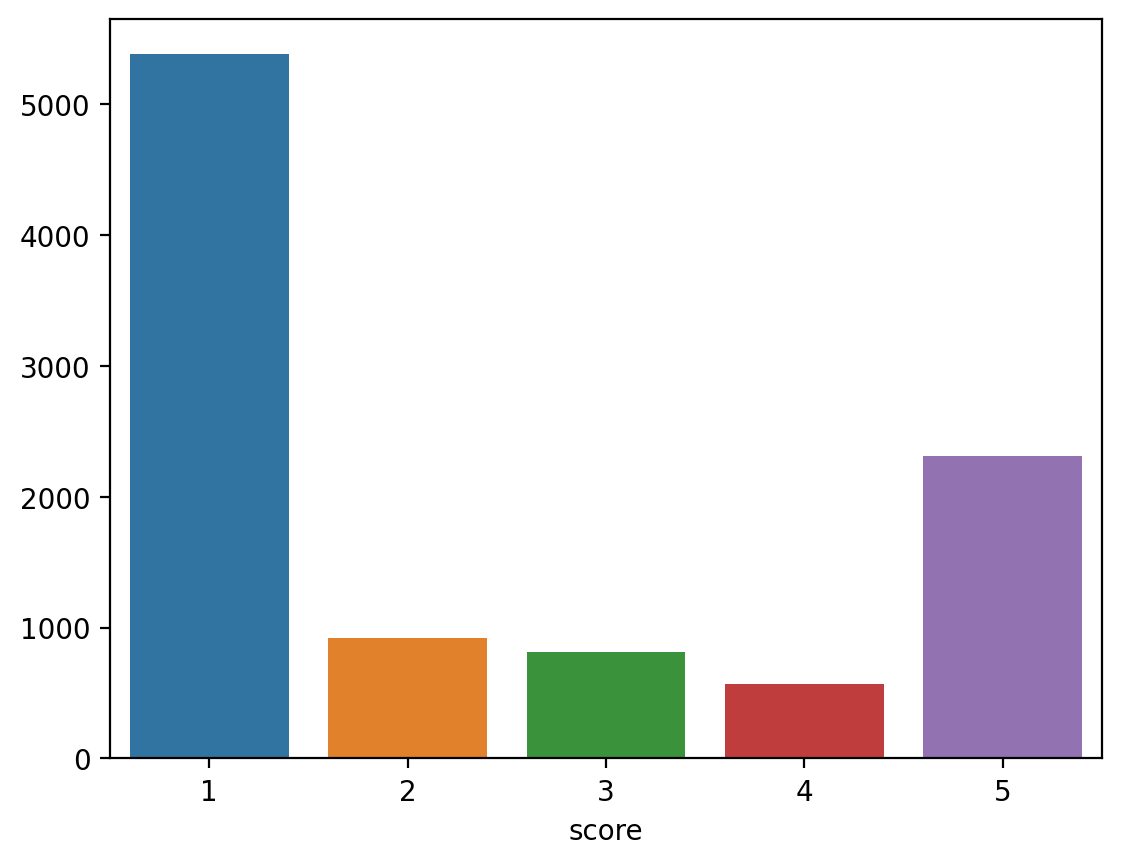

In [7]:
# score visualization
result = df.groupby(['score']).size()
sns.barplot(x=result.index, y=result.values)

In [8]:
sentimen = []

for index, row in df.iterrows():
    if row['score'] > 3:
        sentimen.append(1)
    elif row['score'] == 3:
        sentimen.append(0)
    else:
        sentimen.append(-1)

df['sentiment'] = sentimen
df.head()        

content  score  year  month  day  \
0  Thanks udah bisa digunakan. Apa benar Tokopedi...      5  2024      6   10   
1               Kurir rekomendasi Pengiriman lamaaaa      4  2024      6   10   
2  Sayang sekali appk Tokopedia tidak ada map saa...      3  2024      6    9   
3  Loading muluu, pas mau milih metode pembayaran...      1  2024      6    9   
4      Harga barangnya murah dan berkualitas premium      5  2024      6    9   

   sentiment  
0          1  
1          1  
2          0  
3         -1  
4          1

<Axes: xlabel='sentiment'>

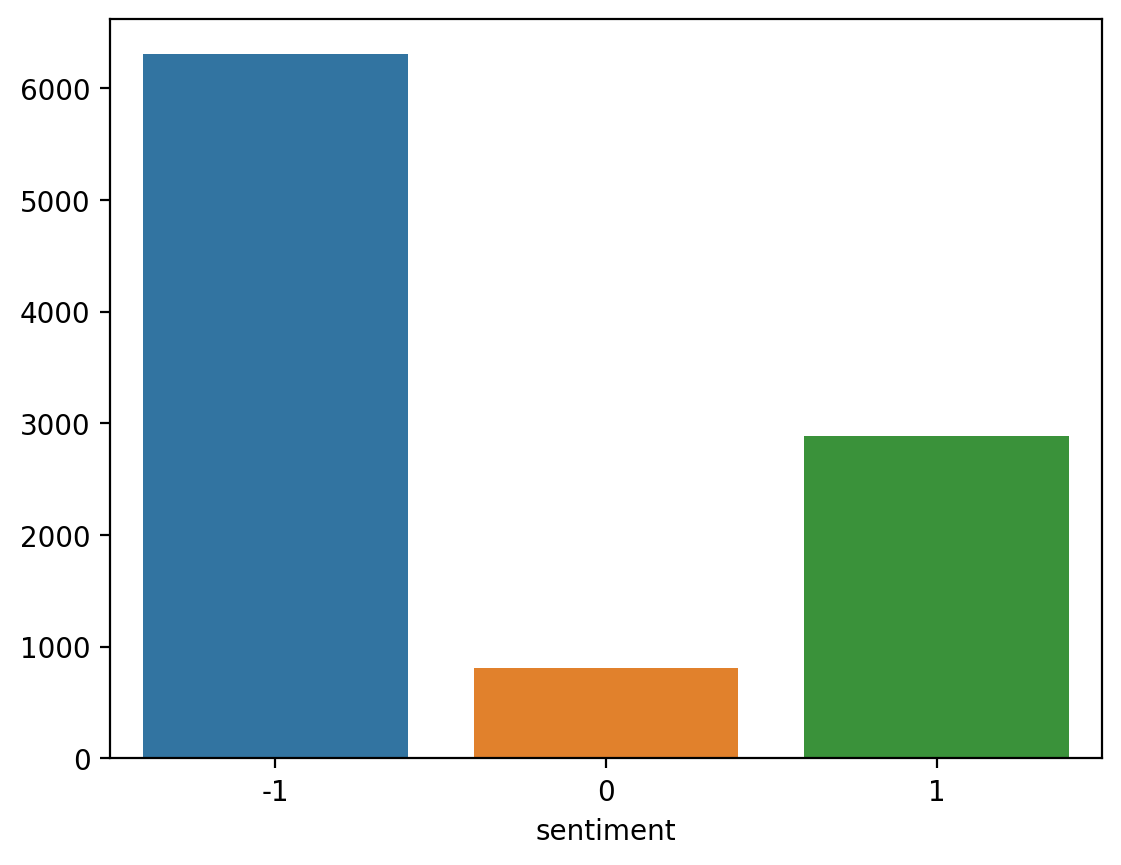

In [9]:
# sentiment distribusion

df2 = df[['year','month','sentiment']]
result = df2.groupby(['sentiment']).size()
sns.barplot(x=result.index, y=result.values)

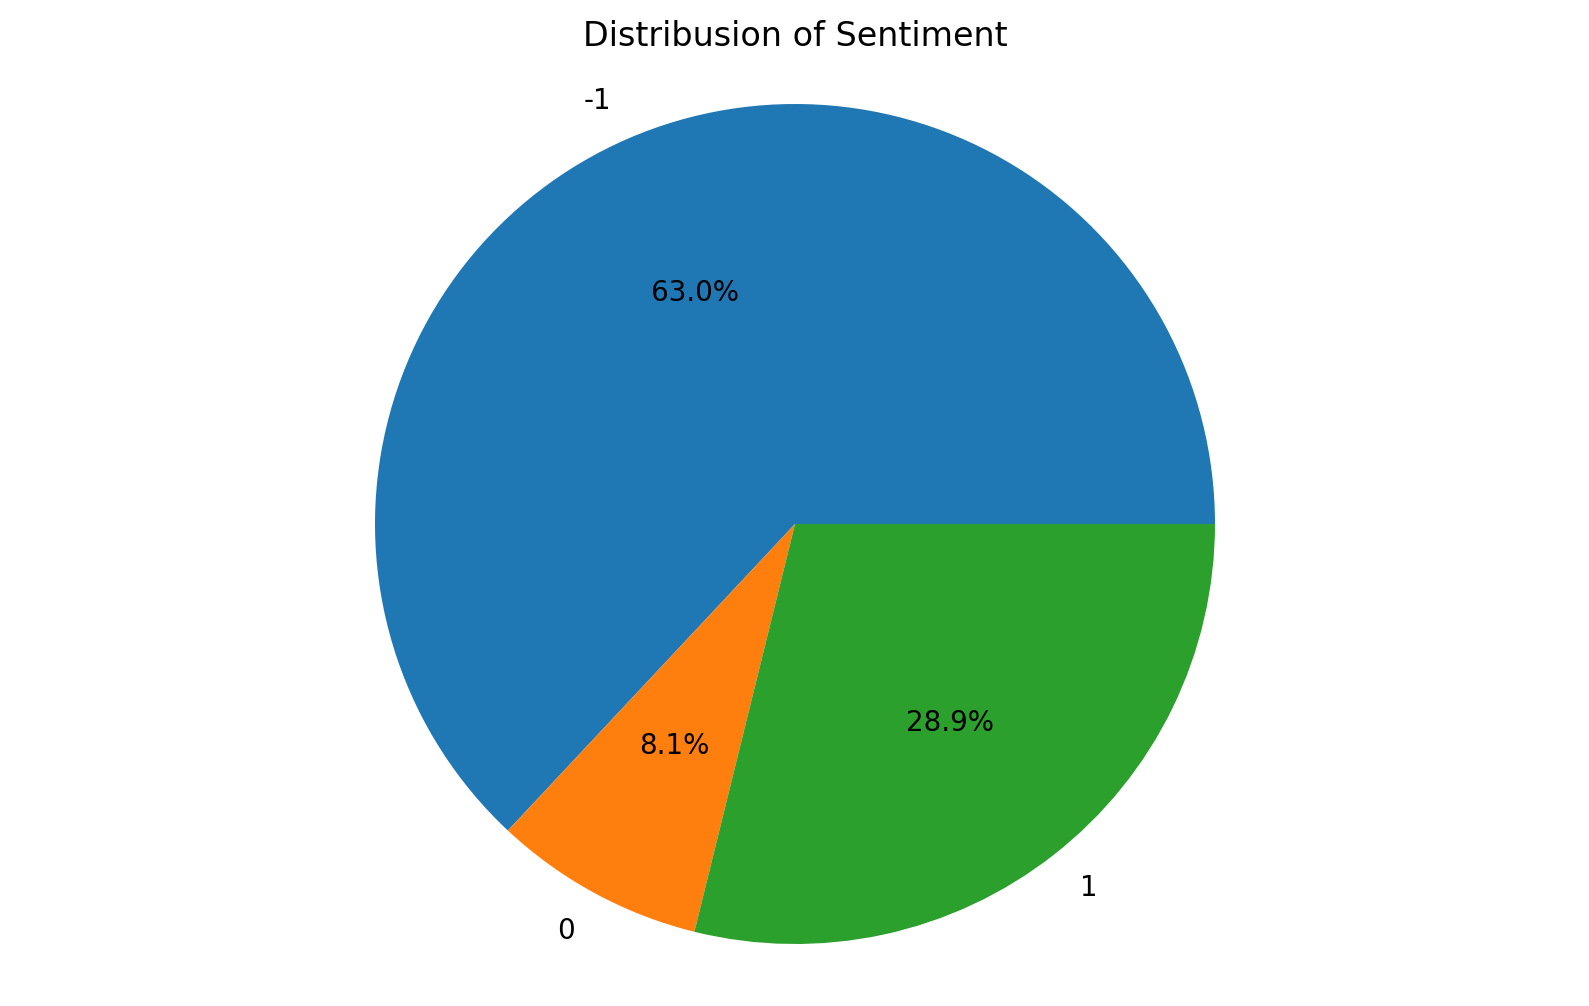

In [10]:
plt.figure(figsize=(10,6))
plt.pie(result.values, labels=result.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Distribusion of Sentiment")
plt.show()

In [11]:
df3 = df2.groupby(['year','sentiment'])
df3 = df3['sentiment'].count()
df3

year  sentiment
2018  -1             76
       0             29
       1            100
2019  -1            249
       0             83
       1            196
2020  -1            377
       0             76
       1            807
2021  -1            367
       0             67
       1            252
2022  -1            570
       0             97
       1            153
2023  -1            437
       0             56
       1             44
2024  -1           4226
       0            405
       1           1333
Name: sentiment, dtype: int64

### text preporcessing

In [12]:
# delete characters

def delete_character(text):
    if text is None:
        return " " # Returns an empty string if the text value is None
    for sp in string.punctuation:
        text = text.replace(sp," ")
    text = re.sub(r"\d+","",text)
    return text.replace('/\s\s+/g', ' ')

data['content'] = data['content'].apply(delete_character)
data.head()

userName  score                  at  \
0  Pengguna Google      5 2024-06-10 17:49:35   
1  Pengguna Google      4 2024-06-10 09:12:58   
2  Pengguna Google      3 2024-06-09 19:24:57   
3  Pengguna Google      1 2024-06-09 18:38:11   
4  Pengguna Google      5 2024-06-09 18:17:32   

                                             content  year  month  day  
0  Thanks udah bisa digunakan  Apa benar Tokopedi...  2024      6   10  
1               Kurir rekomendasi Pengiriman lamaaaa  2024      6   10  
2  Sayang sekali appk Tokopedia tidak ada map saa...  2024      6    9  
3  Loading muluu  pas mau milih metode pembayaran...  2024      6    9  
4      Harga barangnya murah dan berkualitas premium  2024      6    9

In [13]:
df['content'] = df['content'].str.replace('https\S+', ' ', case=False)
df['content'] = df['content'].str.lower()
df['content'] = df['content'].str.replace('@\S+', ' ', case=False)
df['content'] = df['content'].str.replace('#\S+', ' ', case=False)
df['content'] = df['content'].str.replace("\'w+", ' ', case=False)
df['content'] = df['content'].str.replace("[^\w\s]", ' ', case=False)
df['content'] = df['content'].str.replace("\s(2)", ' ', case=False)
regexp = RegexpTokenizer('\w+')
df['content_token'] = df['content'].apply(regexp.tokenize)


In [14]:
df.head()

content  score  year  month  day  \
0  thanks udah bisa digunakan. apa benar tokopedi...      5  2024      6   10   
1               kurir rekomendasi pengiriman lamaaaa      4  2024      6   10   
2  sayang sekali appk tokopedia tidak ada map saa...      3  2024      6    9   
3  loading muluu, pas mau milih metode pembayaran...      1  2024      6    9   
4      harga barangnya murah dan berkualitas premium      5  2024      6    9   

   sentiment                                      content_token  
0          1  [thanks, udah, bisa, digunakan, apa, benar, to...  
1          1          [kurir, rekomendasi, pengiriman, lamaaaa]  
2          0  [sayang, sekali, appk, tokopedia, tidak, ada, ...  
3         -1  [loading, muluu, pas, mau, milih, metode, pemb...  
4          1  [harga, barangnya, murah, dan, berkualitas, pr...

### filtering (stopword removal)


In [15]:
# make a list of indonesian stopwords
stopwords = nltk.corpus.stopwords.words('indonesian')

# extend the list with your own custom stopwords
my_stopwords = ['tokopedia','tokped','']
stopwords.extend(my_stopwords)

# remove stopwords
df['content_token'] = df['content_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head()

content  score  year  month  day  \
0  thanks udah bisa digunakan. apa benar tokopedi...      5  2024      6   10   
1               kurir rekomendasi pengiriman lamaaaa      4  2024      6   10   
2  sayang sekali appk tokopedia tidak ada map saa...      3  2024      6    9   
3  loading muluu, pas mau milih metode pembayaran...      1  2024      6    9   
4      harga barangnya murah dan berkualitas premium      5  2024      6    9   

   sentiment                                      content_token  
0          1  [thanks, udah, tik, tok, bikin, card, gratis, ...  
1          1          [kurir, rekomendasi, pengiriman, lamaaaa]  
2          0  [sayang, appk, map, lacak, posisi, pesanan, ka...  
3         -1  [loading, muluu, pas, milih, metode, pembayara...  
4          1    [harga, barangnya, murah, berkualitas, premium]

### stemming sastrawi

In [16]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
df['stemmed'] = df['content_token'].apply(lambda x: [stemmer.stem(y) for y in x])
df.head()

content  score  year  month  day  \
0  thanks udah bisa digunakan. apa benar tokopedi...      5  2024      6   10   
1               kurir rekomendasi pengiriman lamaaaa      4  2024      6   10   
2  sayang sekali appk tokopedia tidak ada map saa...      3  2024      6    9   
3  loading muluu, pas mau milih metode pembayaran...      1  2024      6    9   
4      harga barangnya murah dan berkualitas premium      5  2024      6    9   

   sentiment                                      content_token  \
0          1  [thanks, udah, tik, tok, bikin, card, gratis, ...   
1          1          [kurir, rekomendasi, pengiriman, lamaaaa]   
2          0  [sayang, appk, map, lacak, posisi, pesanan, ka...   
3         -1  [loading, muluu, pas, milih, metode, pembayara...   
4          1    [harga, barangnya, murah, berkualitas, premium]   

                                             stemmed  
0  [thanks, udah, tik, tok, bikin, card, gratis, ...  
1               [kurir, rekomendasi, kirim, lamaaaa]  
2  [sayang, appk, map, lacak, posisi, pesan, kalo...  
3  [loading, muluu, pas, milih, metode, bayar, lo...  
4          [harga, barang, murah, kualitas, premium]

In [17]:
# delete token less 4 characters
df['text_string'] = df['stemmed'].apply(lambda x: ' '.join([item for item in x if len(item)>3]))
df.head()

content  score  year  month  day  \
0  thanks udah bisa digunakan. apa benar tokopedi...      5  2024      6   10   
1               kurir rekomendasi pengiriman lamaaaa      4  2024      6   10   
2  sayang sekali appk tokopedia tidak ada map saa...      3  2024      6    9   
3  loading muluu, pas mau milih metode pembayaran...      1  2024      6    9   
4      harga barangnya murah dan berkualitas premium      5  2024      6    9   

   sentiment                                      content_token  \
0          1  [thanks, udah, tik, tok, bikin, card, gratis, ...   
1          1          [kurir, rekomendasi, pengiriman, lamaaaa]   
2          0  [sayang, appk, map, lacak, posisi, pesanan, ka...   
3         -1  [loading, muluu, pas, milih, metode, pembayara...   
4          1    [harga, barangnya, murah, berkualitas, premium]   

                                             stemmed  \
0  [thanks, udah, tik, tok, bikin, card, gratis, ...   
1               [kurir, rekomendasi, kirim, lamaaaa]   
2  [sayang, appk, map, lacak, posisi, pesan, kalo...   
3  [loading, muluu, pas, milih, metode, bayar, lo...   
4          [harga, barang, murah, kualitas, premium]   

                                         text_string  
0  thanks udah bikin card gratis bayar maksud kre...  
1                    kurir rekomendasi kirim lamaaaa  
2  sayang appk lacak posisi pesan kalok kasih sar...  
3  loading muluu milih metode bayar loading ujung...  
4                harga barang murah kualitas premium

In [18]:
# change text_string column from object to string
df['text_string'] = df['text_string'].astype('str')
df['text_string'] = df['text_string'].astype(pd.StringDtype())
df.dtypes

content                  object
score                     int64
year                      int32
month                     int32
day                       int32
sentiment                 int64
content_token            object
stemmed                  object
text_string      string[python]
dtype: object

In [19]:
# filter only positive sentiment
df_p = df[df['sentiment']==1]
all_words_lem = ' '.join([word for word in df_p['text_string']])

Text(0.5, 1.0, 'Positive Sentiment')

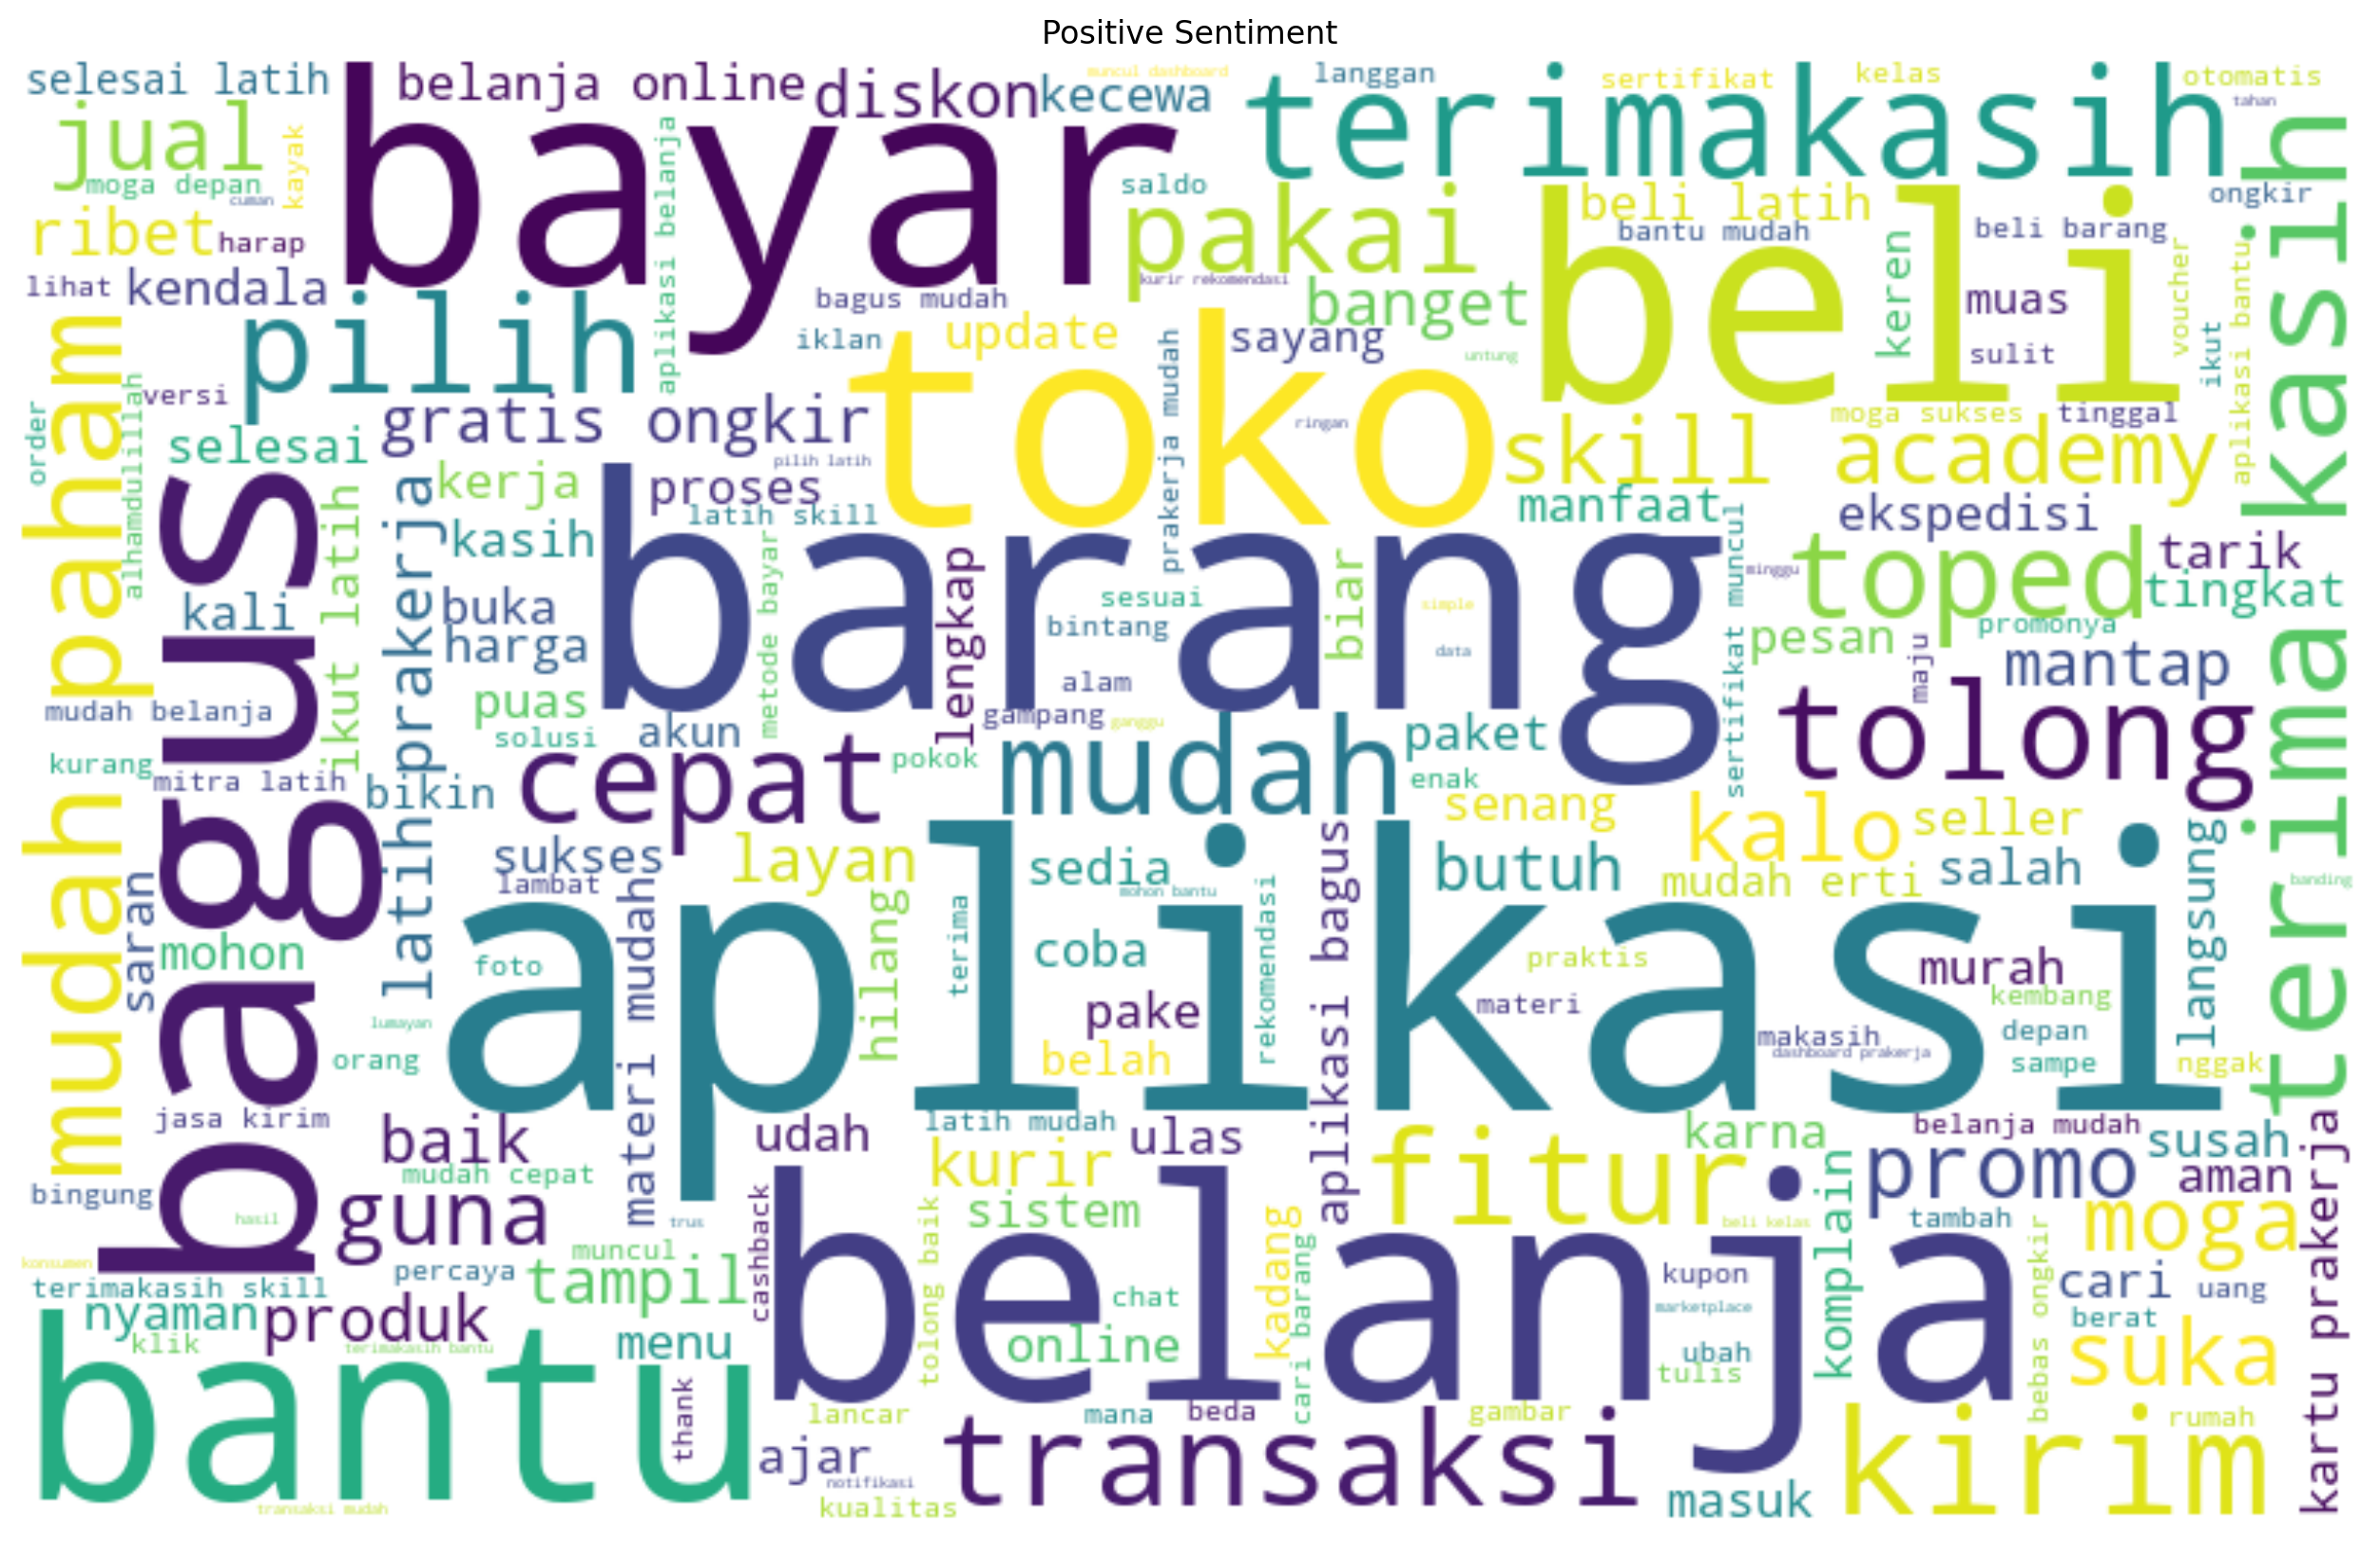

In [20]:
wordcloud = WordCloud(background_color='white',
                     width=800,
                     height=500,
                     random_state=21,
                     max_font_size=130).generate(all_words_lem)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment')

In [21]:
# filter only negative sentiment
df_neg = df[df['sentiment']==-1]
all_words_lemneg = ' '.join([word for word in df_neg['text_string']])

Text(0.5, 1.0, 'Negative Sentiment')

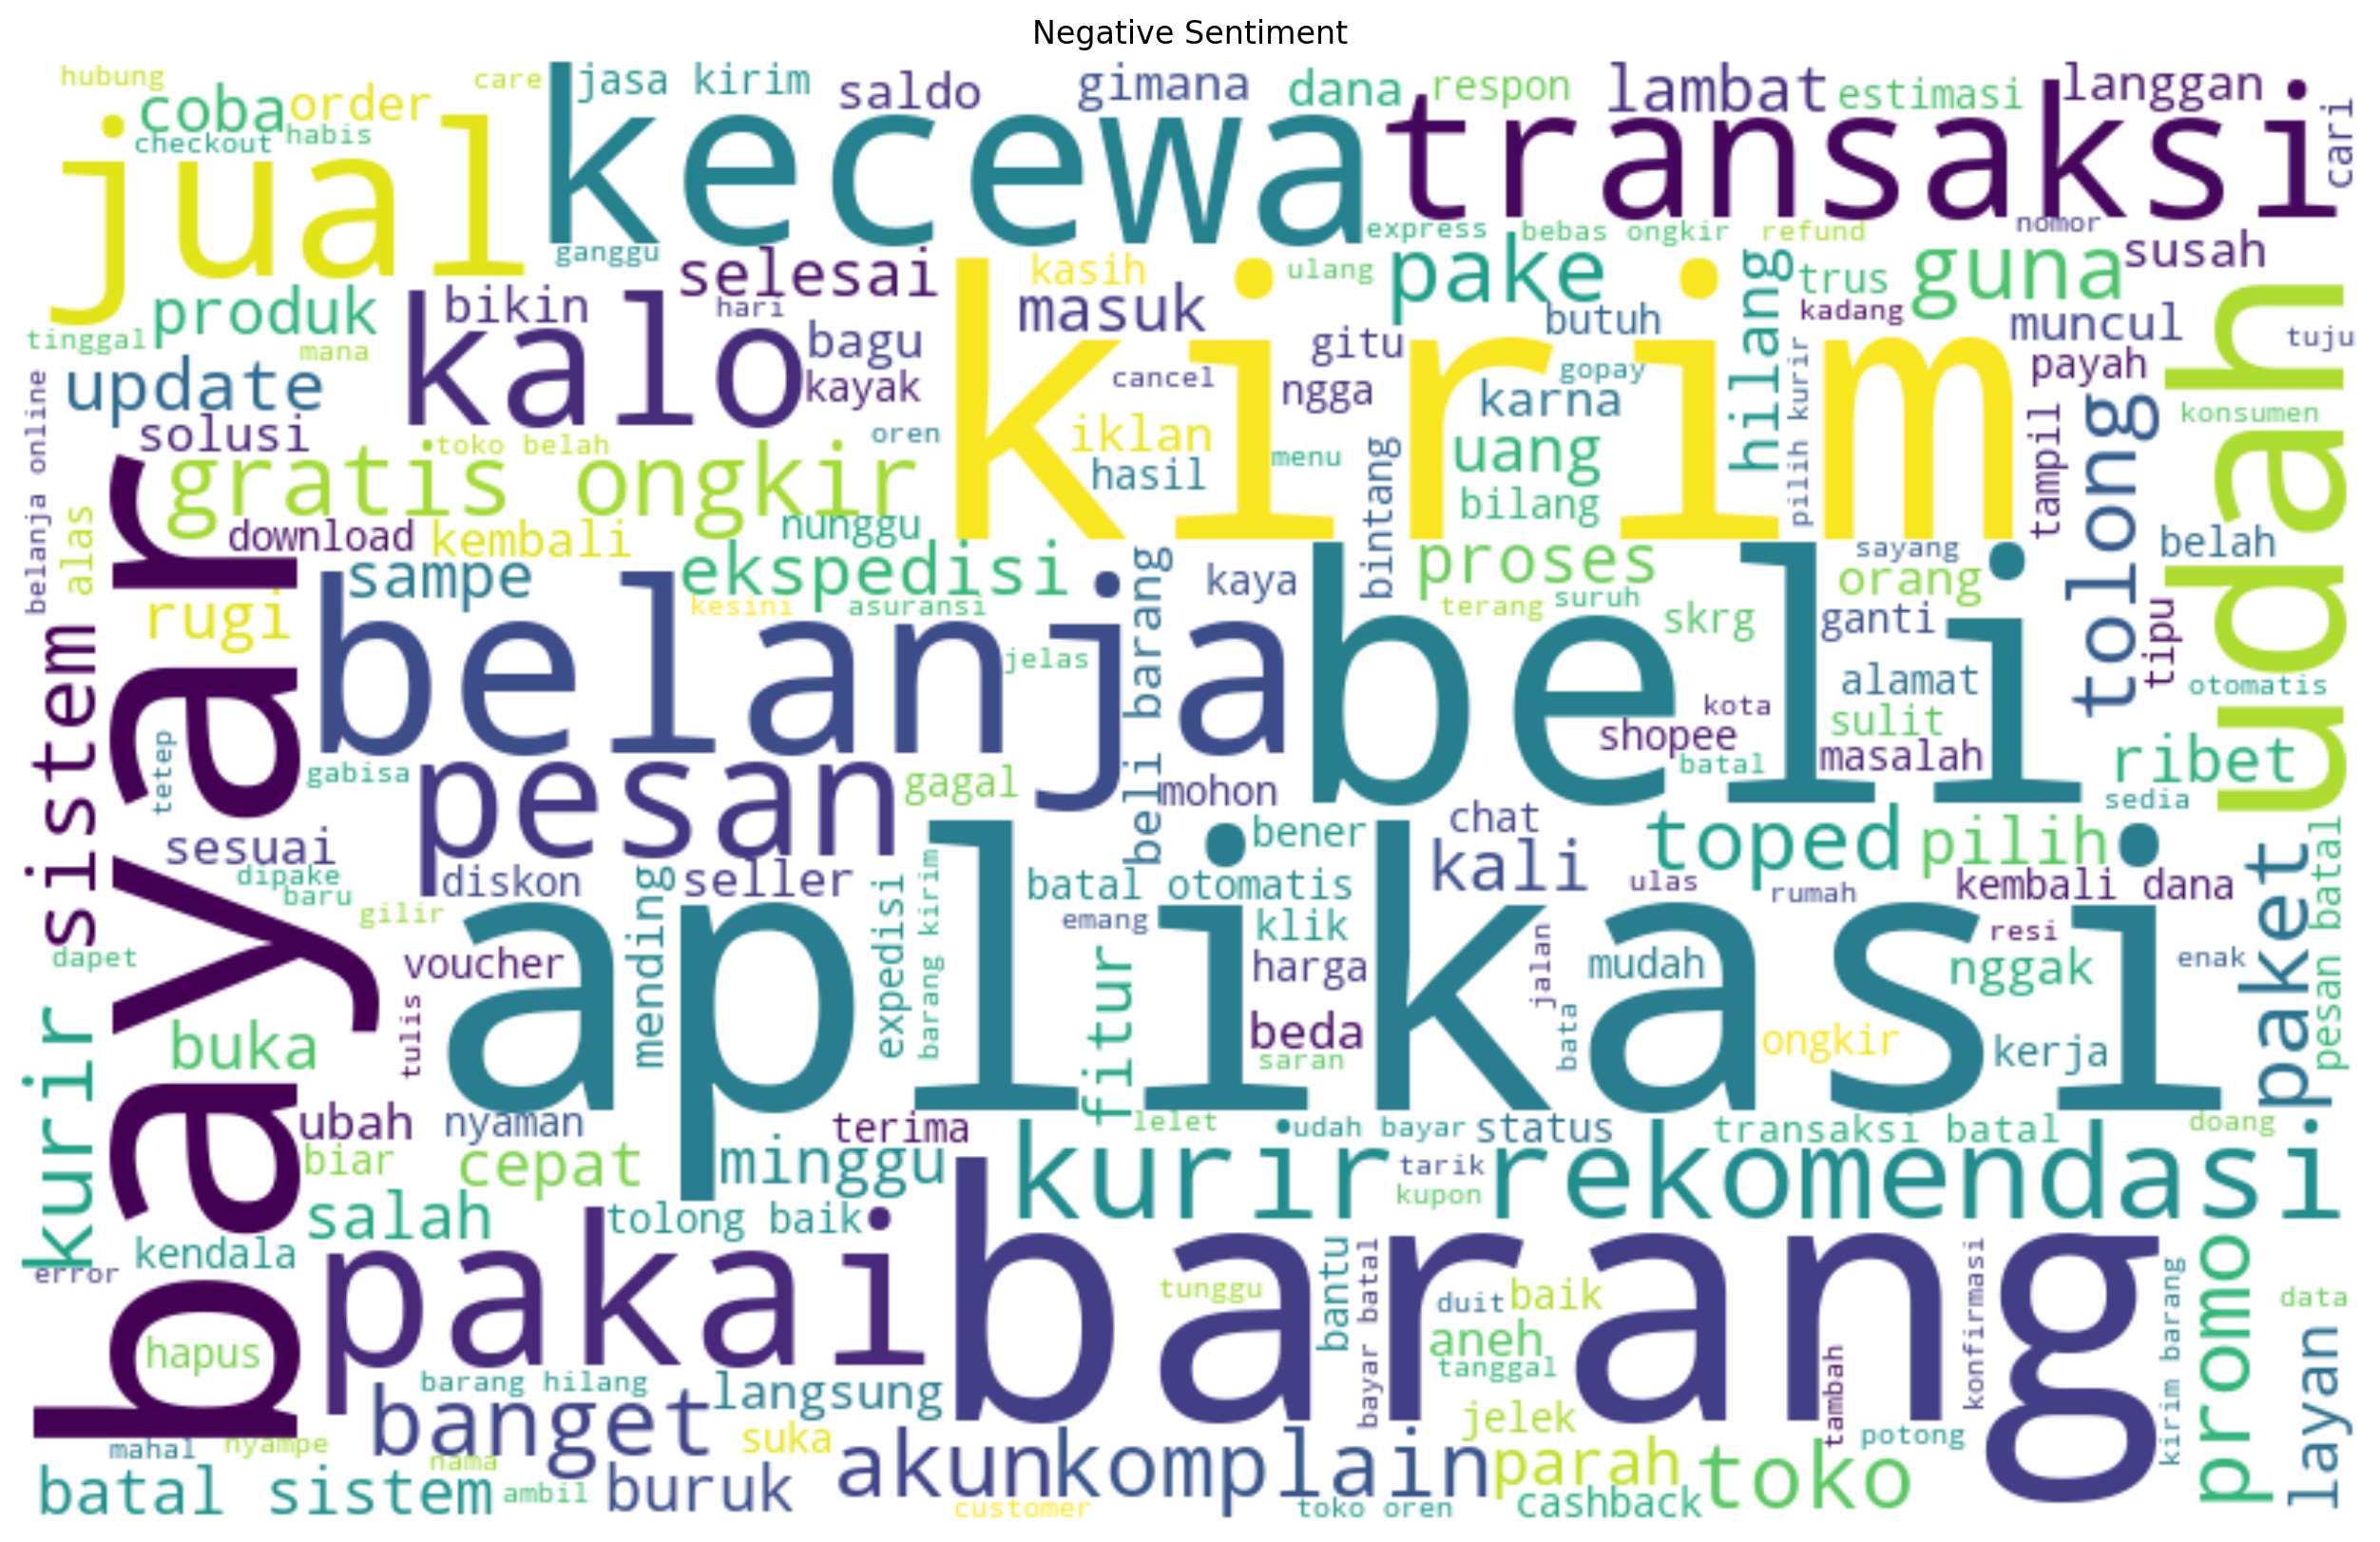

In [22]:
wordcloud = WordCloud(background_color='white',
                     width=800,
                     height=500,
                     random_state=21,
                     max_font_size=130).generate(all_words_lemneg)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment')

In [23]:
df_net = df[df['sentiment']==0]
all_words_lemnet = ' '.join([word for word in df_net['text_string']])

Text(0.5, 1.0, 'Netral Sentiment')

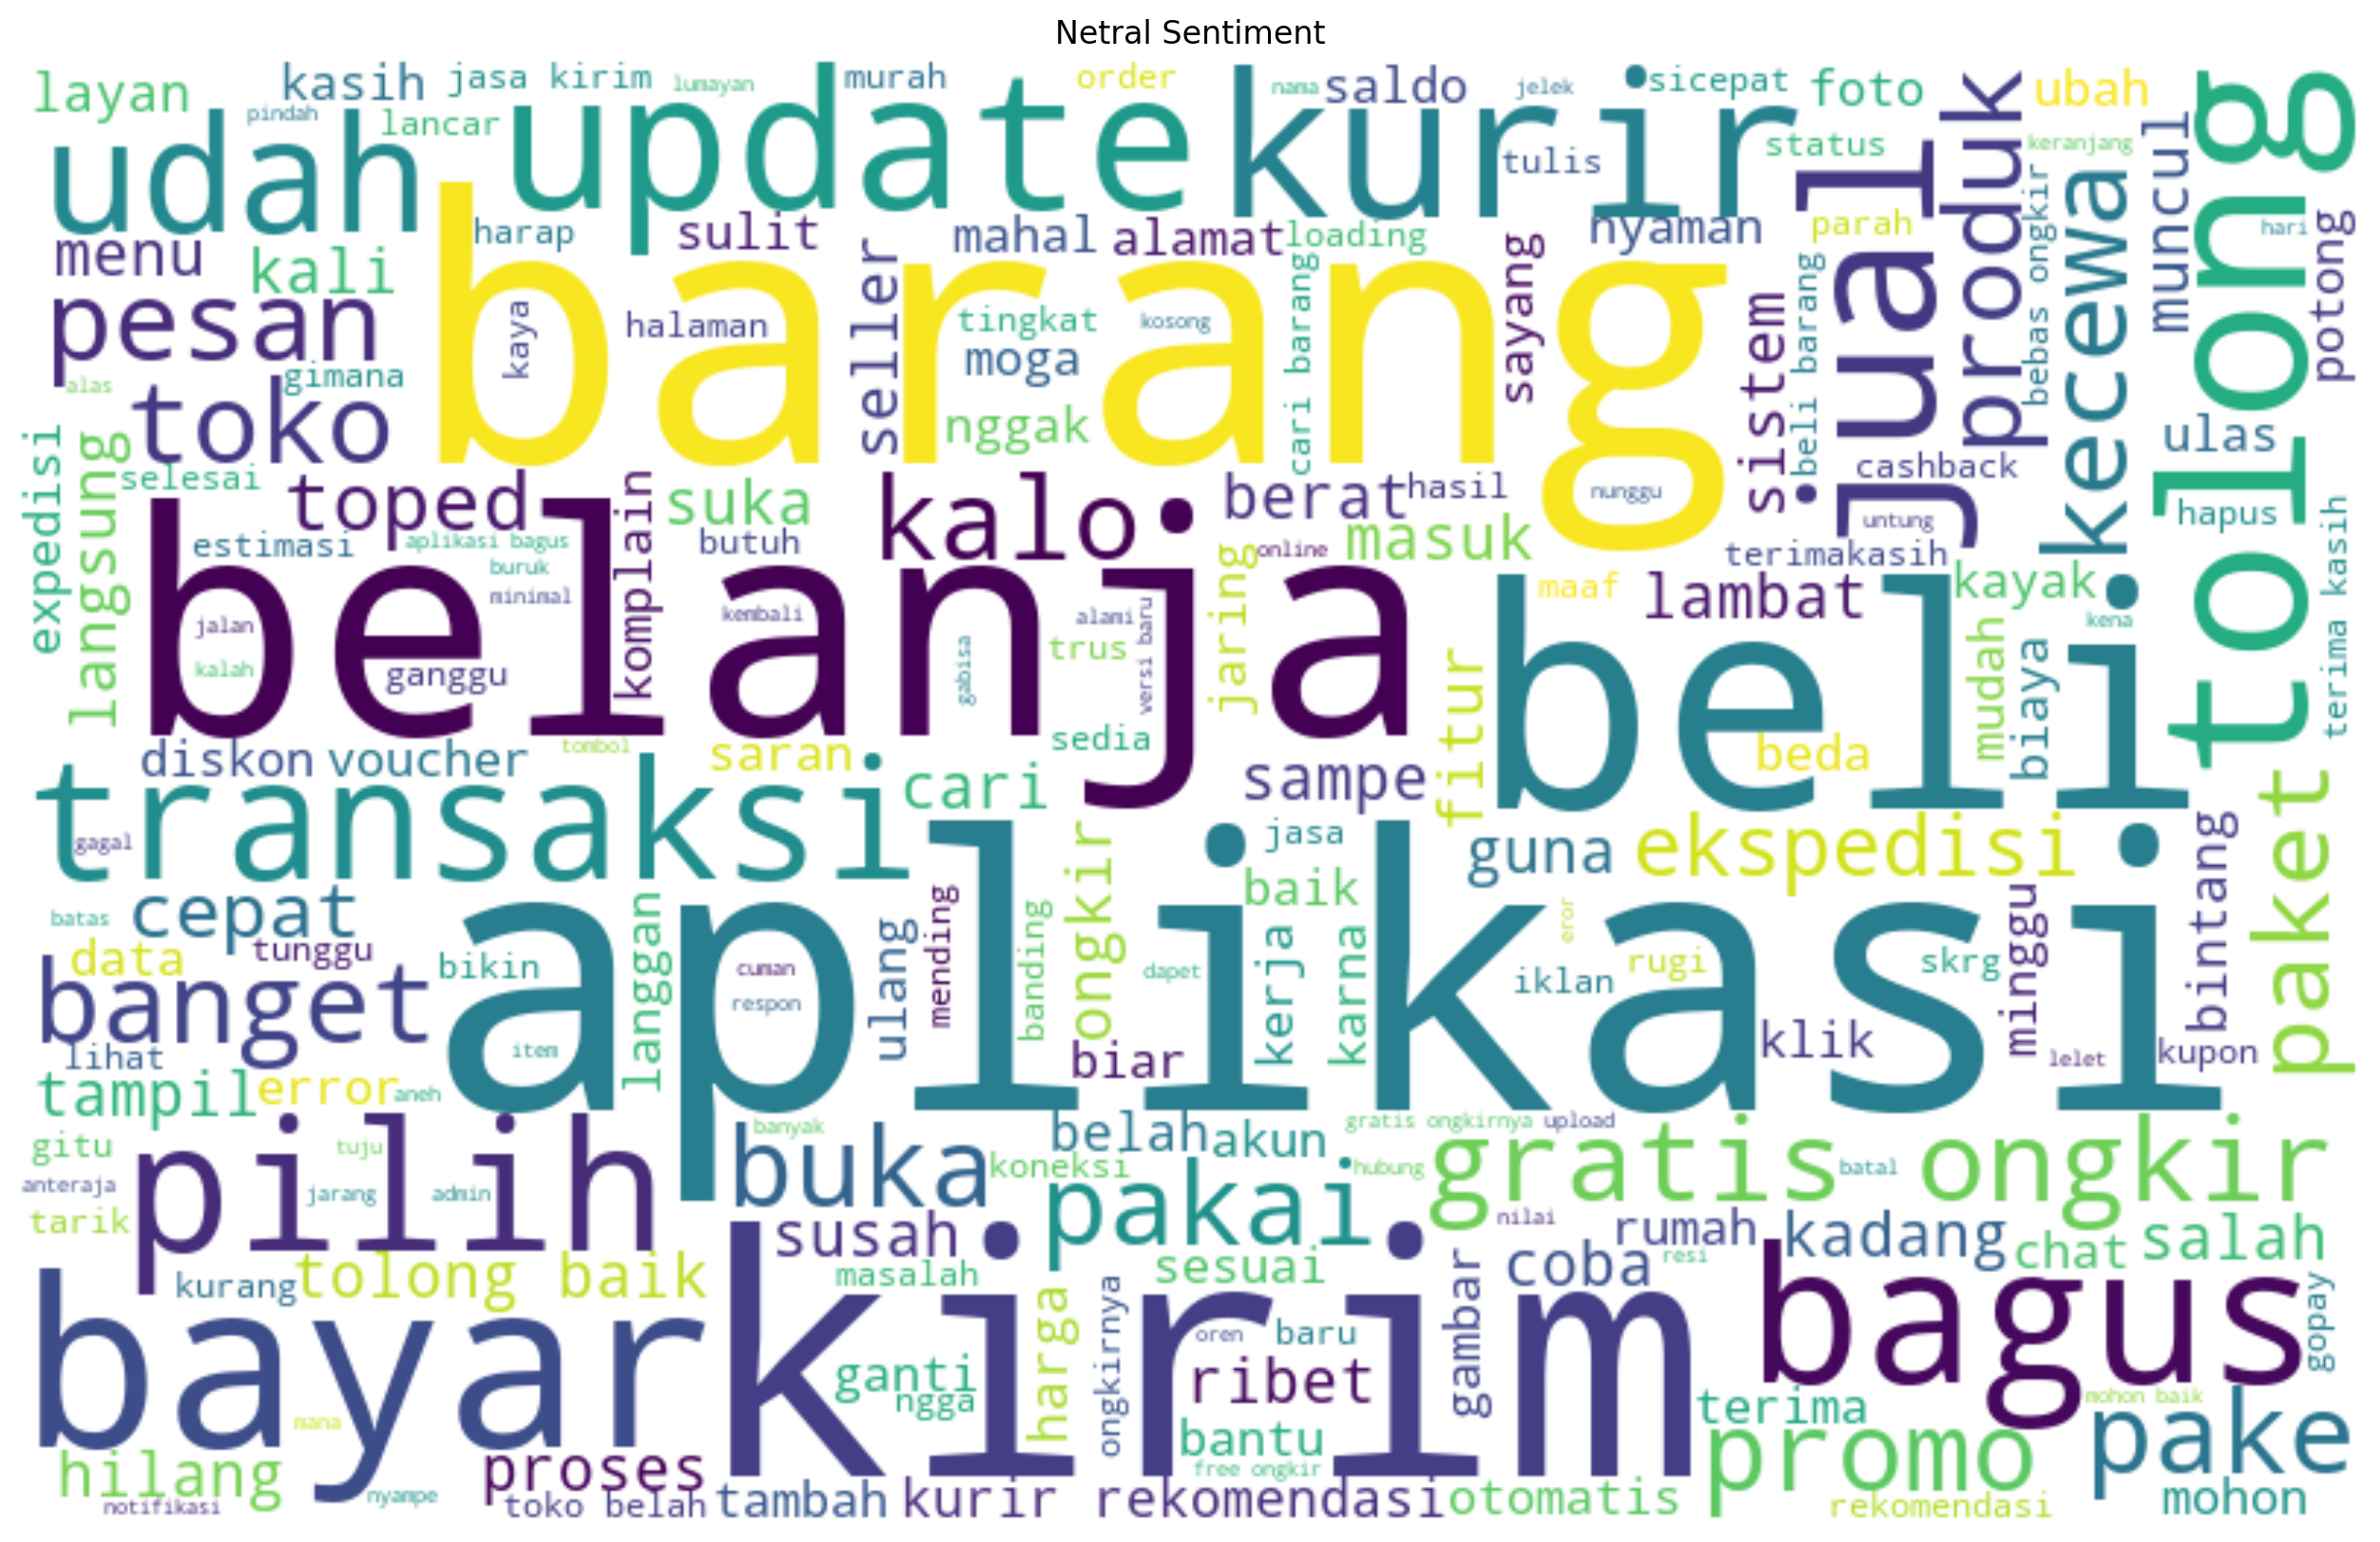

In [24]:
wordcloud = WordCloud(background_color='white',
                     width=800,
                     height=500,
                     random_state=21,
                     max_font_size=130).generate(all_words_lemnet)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Netral Sentiment')

## Sentiment Analysis With Random Forest, SVM, and  Naive Bayes

#### TF-IDF

In [27]:
X = df['text_string']
y = df['sentiment']
tfid = TfidfVectorizer()
X_final = tfid.fit_transform(X)

#### Handling Imbalance

In [28]:
# handling imbalanced using SMOTE
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(X_final,y)

#### Setimen Analisis

##### split data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.1, random_state=3)

##### random forest

In [30]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,y_train)
random_forest_classifier_prediction = random_forest_classifier.predict(X_test)
accuracy_score(random_forest_classifier_prediction,y_test)

0.9190904283447912

##### SVM

In [31]:
svm = SVC()
svm.fit(X_train,y_train)
svm_prediction = svm.predict(X_test)
accuracy_score(svm_prediction,y_test)

0.9212057112638815

##### Naive Bayes

In [32]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_prediction = nb.predict(X_test)
accuracy_score(nb_prediction,y_test)

0.7789529349550502

## Kesimpulan

Nilai akurasi tertinggi adalah sebesar 92,12% yang diperoleh dari metode Super Vector Machine (SVM) dengan perbandingan split data sebesar 90:10.

##### Scraping data Tokopedia: https://github.com/gioprana89/scraping-google-play
##### NLP: https://medium.com/@aliyatulmunna7/analisis-sentimen-aplikasi-gojek-di-playstore-menggunakan-python-dengan-algoritma-random-forest-2e5504090f9b